In [8]:
import numpy as np
import networkx as nx
import pickle as pic
import os
from scipy import interpolate
from IPython.display import Image
from tqdm.auto import tqdm
import json
from pathlib import Path

# import time

from cassiopeia.data.CassiopeiaTree import CassiopeiaTree
from cassiopeia.simulator.TreeSimulator import TreeSimulatorError
from cassiopeia.simulator.BirthDeathFitnessSimulator import (
    BirthDeathFitnessSimulator,
)
from cassiopeia.simulator.UniformLeafSubsampler import UniformLeafSubsampler


In [3]:
# load config
with open('config.json', 'r') as f:
    config = json.load(f)

In [65]:
def estimate_birth_death_rate_ml_stem(t, n, e):
    r = np.log(n)/t
    return r/(1-e), r/(1-e) * e

def estimate_birth_death_rate_mom_stem(t, n, e):
    r = np.log(n * (1 - e) + e)/t
    return r/(1-e), r/(1-e) * e

def generate_topology(
    birth_waiting_distribution,
    initial_birth_scale,
    death_waiting_distribution,
    mutation_distribution,
    fitness_distribution,
    fitness_base,
    total_time,
    ratio, #subsampling ratio
    top_path, #the path in which to save the tree
    seed = None, #optional seed
    seen_seeds = [] #records which seeds have been seed in order to prevent duplicates
):
    
    # If we generate a tree that is smaller than `num_extant` * subsampling ratio,
    # or if we generate a tree that dies before the stopping condition, 
    # we need to generate again. If a seed is passed, we need to increment the seed
    # until we find a seed that procudes a valid tree. This final seed is returned.
    size = 0
    if seed is not None:
        seed -= 1
    while size <= 0:
        if seed is not None:
            seed += 1
            while seed in seen_seeds:
                seed += 1
        try:
            bd_sim = BirthDeathFitnessSimulator(
                birth_waiting_distribution = birth_waiting_distribution,
                initial_birth_scale = initial_birth_scale,
                death_waiting_distribution = death_waiting_distribution,
                mutation_distribution = mutation_distribution,
                fitness_distribution = fitness_distribution,
                fitness_base = fitness_base,
                experiment_time = total_time,
                random_seed = seed
            )
            topology = bd_sim.simulate_tree()
            size = topology.n_cell
        except TreeSimulatorError:
            size = 0
            
    # Subsample, collapse from the root child in order to preserve hanging edge from root
    root_child = topology.children(topology.root)[0]
    if ratio < 1:
        subsampler = UniformLeafSubsampler(ratio = ratio)
        topology = subsampler.subsample_leaves(tree=topology, keep_singular_root_edge=True)
    topology.relabel_nodes(dict(zip(topology.leaves, ["c" + i for i in topology.leaves])))
    
    # Saves the tree at the specified path, returns relevant tree stats
    pic.dump(topology, open(top_path, 'wb'))
    if seed is not None:
        return size, seed
    else:
        return size

In [97]:
top_folder = config['top_dir']
seed_path = os.path.join(config['seed_dir'], '030922.sim_topology.txt')
num_topologies = 50 #config['num_trees']
topology_name = config['topologies'][0]
ratio = 0.2
n_leaves = None
num_extant = 400

exp_time = config['time']
t = 0.935 - 0.02 * np.log2(2000)
c = 0.02
fitness_regimes = {
    "no_fit": (None, None, None)
}


birth_waiting_distribution = lambda scale: np.random.exponential(scale) + c
initial_birth_rate, death_rate = estimate_birth_death_rate_ml_stem(t, num_extant, 0.1)
initial_birth_scale = 1/initial_birth_rate
death_waiting_distribution = lambda: np.random.exponential(1/death_rate + c)

seen_seeds = []
for fitness in fitness_regimes:
    print(fitness)
    mutation_distribution, fitness_distribution, fitness_base = fitness_regimes[fitness]
    top_path =  top_folder.format(
        topology=topology_name,
        time=exp_time,
        fitness_regime=fitness
    )
    print(top_path)
    if os.path.exists(top_path) == False:
        Path(top_path).mkdir(parents=True, exist_ok=True)
    seeds = np.random.choice(range(1000000), num_topologies, replace = False)
    sizes = []
    for num in tqdm(range(num_topologies)):
        seed = seeds[num]
        size, final_seed = generate_topology(
            birth_waiting_distribution = birth_waiting_distribution,
            initial_birth_scale = initial_birth_scale,
            death_waiting_distribution = death_waiting_distribution,
            mutation_distribution = mutation_distribution,
            fitness_distribution = fitness_distribution,
            fitness_base = fitness_base,
            total_time = 1,
            ratio = ratio,
            top_path = top_path + "topology" + str(num) + ".pkl",
            seed = seed,
            seen_seeds = seen_seeds
        )
        seen_seeds.append(final_seed)
        sizes.append(size)

        # seed record
        Path(os.path.dirname(seed_path)).mkdir(parents=True, exist_ok=True)
        f = open(seed_path, "a")
        f.write(str(num_extant) + "\t" + fitness + "\t" + str(num) + "\t" + str(final_seed) + "\n")
        f.close()
        # print(num, size)

no_fit
/home/eecs/ivalexander13/datadir/simulation_data/topologies/exponential_plus_c/time1/no_fit/


  0%|          | 0/50 [00:00<?, ?it/s]

(388.02, 333.0)

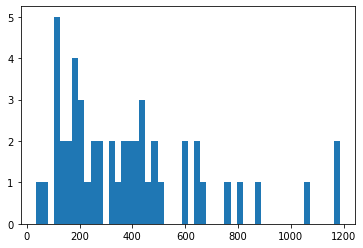

In [98]:
import matplotlib.pyplot as plt

plt.hist(sizes, bins=50);
np.mean(sizes), np.median(sizes)